In [39]:

import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn import preprocessing
from sklearn.utils import shuffle
from category_encoders import BinaryEncoder
from sklearn import preprocessing
from sklearn.utils import resample

from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

import joblib
import pickle

# 1. DATA pre-prosessing part

####  1.1    Load training data and labels

In [40]:
train_data = pd.read_csv('orange_small_train.data', sep = '\t')
appetency = pd.read_csv('orange_small_train_appetency_train.labels',header=None).astype('float')
churn = pd.read_csv('orange_small_train_churn_train.labels', header=None).astype('float')
upselling = pd.read_csv('orange_small_train_upselling_train.labels',header=None).astype('float')

appetency.columns = ['appetency']
churn.columns = ['churn']
upselling.columns = ['upselling']
churn = (churn + 1)/2
upselling = (upselling + 1)/2
appetency = (appetency + 1)/2

#### 1.2     Dictionary to save the info used by test.py

In [41]:
train_info_dic={}
train_info_dic['orig_columns']=train_data.columns

#### 1.3 Drop the columns all with nan

In [42]:
column_names = train_data.columns #all rows has at least one feature...
drop_list = [x for x in column_names if len([ y for y in train_data.loc[:,x].isna() if y == True]) == train_data.shape[0]]
train_data_drop_na = train_data.drop(drop_list,axis=1)
train_info_dic['drop_list'] = drop_list

#### 1.4 Convert object --> category 

In [43]:
category_columns = train_data_drop_na.select_dtypes(['object']).columns
train_data_drop_na[category_columns] = train_data_drop_na[category_columns].apply(lambda col: col.astype('category'))
numberic_columns = train_data_drop_na.select_dtypes(exclude=['category']).columns

#### 1.5 For numberic columns whose categories num less than 5, treat it as category type

In [44]:
num_to_categorical=[]
for col in numberic_columns:
    if len(train_data_drop_na[col].value_counts().to_dict()) < 5:
        num_to_categorical.append(col)
train_info_dic['num_to_categorical'] = num_to_categorical
train_data_drna_nu2ca = train_data_drop_na.copy()
train_data_drna_nu2ca[num_to_categorical]=train_data_drop_na[num_to_categorical].apply(lambda col: col.astype('category'))
category_columns_list = category_columns.tolist()
numberic_columns_list = numberic_columns.tolist()
category_columns_list += num_to_categorical
numberic_columns_list = [col for col in numberic_columns_list if col not in num_to_categorical]
train_info_dic['category_columns'] = category_columns_list
train_info_dic['numberic_columns'] = numberic_columns_list

In [45]:
#### impute data with the nearest ones, not good.

In [46]:
'''
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=5, random_state=0)
imp.fit(train_data_drop_na[numberic_columns])  
train_data_drop_na_imputed = imp.transform(train_data_drop_na[numberic_columns])
train_data_drop_na[numberic_columns] = pd.DataFrame(train_data_drop_na_imputed)
train_data_drna_mean = train_data_drop_na
train_info_dic['imp'] = imp
'''

"\nimport numpy as np\nfrom sklearn.experimental import enable_iterative_imputer\nfrom sklearn.impute import IterativeImputer\nimp = IterativeImputer(max_iter=5, random_state=0)\nimp.fit(train_data_drop_na[numberic_columns])  \ntrain_data_drop_na_imputed = imp.transform(train_data_drop_na[numberic_columns])\ntrain_data_drop_na[numberic_columns] = pd.DataFrame(train_data_drop_na_imputed)\ntrain_data_drna_mean = train_data_drop_na\ntrain_info_dic['imp'] = imp\n"

#### 1.4 Handle numberic value

#### 1.4.1 fill with mean

In [47]:
train_data_drna_nu2ca_mean = train_data_drna_nu2ca
train_data_drna_nu2ca_mean[numberic_columns_list] = train_data_drna_nu2ca[numberic_columns_list].fillna(train_data_drna_nu2ca[numberic_columns_list].mean())
train_info_dic['train_data_mean'] = train_data_drna_nu2ca[numberic_columns_list].mean()

#### 1.6 Scale

In [48]:

train_data_drna_nu2ca_mean_scale = train_data_drna_nu2ca_mean
std_scaler = preprocessing.StandardScaler().fit(train_data_drna_nu2ca_mean[numberic_columns_list])
train_data_drna_nu2ca_mean_scale[numberic_columns_list] = std_scaler.transform(train_data_drna_nu2ca_mean[numberic_columns_list])
train_info_dic['std_scaler'] = std_scaler

#### 1.5 Handle category columns

##### 1.5.1 Binary encoding

In [49]:
binary_encoder = BinaryEncoder(cols=category_columns_list)
train_data_drna_nu2ca_mean_scale_bin  = binary_encoder.fit_transform(train_data_drna_nu2ca_mean_scale)
train_info_dic['binary_encoder'] = binary_encoder

#### 1.7 Save training info

In [50]:
with open('train_info_dic.pkl','wb') as f:
    pickle.dump(train_info_dic,f)

#### 1.8  Resample

<BarContainer object of 2 artists>

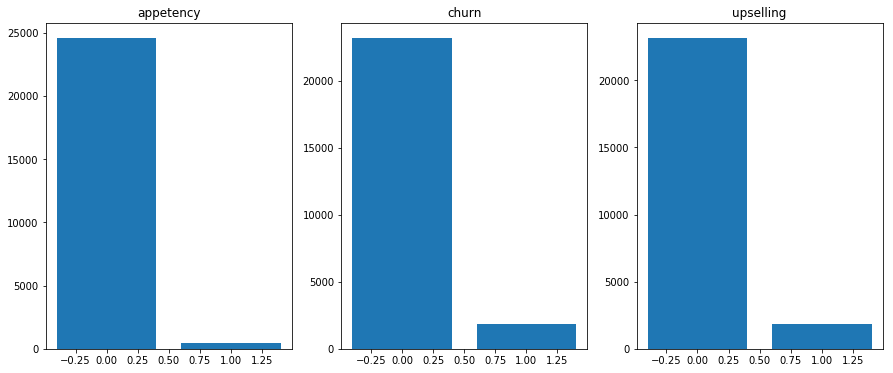

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(1,figsize=(15,6))
plt.subplot(131)
plt.title("appetency")
plt.bar([0,1],[len(appetency[appetency.appetency <= 0]),len(appetency[appetency.appetency > 0])])
plt.subplot(132)
plt.title("churn")
plt.bar([0,1],[len(appetency[churn.churn <= 0]),len(appetency[churn.churn > 0])])
plt.subplot(133)
plt.title("upselling")
plt.bar([0,1],[len(appetency[upselling.upselling <= 0]),len(appetency[upselling.upselling > 0])])

In [52]:
##### Random Up sampling , not good
##### SMOTE, not good
##### Choose random downsampling

RANDOM_SEED = 320
train_data_drna_nu2ca_mean_scale_bin_pd = pd.DataFrame(train_data_drna_nu2ca_mean_scale_bin)
processed_train_data_with_appetency = pd.concat([train_data_drna_nu2ca_mean_scale_bin_pd,appetency],axis=1)
df_maj_with_appetency = processed_train_data_with_appetency[processed_train_data_with_appetency.appetency==0]
df_min_with_appetency = processed_train_data_with_appetency[processed_train_data_with_appetency.appetency==1]
df_maj_downsampled_appetency = resample(df_maj_with_appetency, replace=True, n_samples=df_min_with_appetency .shape[0]*10, random_state=RANDOM_SEED) # reproducible resultsRANDOM_SEED
df_downsampled_appetency = pd.concat([df_min_with_appetency, df_maj_downsampled_appetency])
df_downsampled_shuffled_appetency =shuffle(df_downsampled_appetency)
df_X_appetency = df_downsampled_shuffled_appetency.drop(['appetency'],axis=1)
df_y_appetency = df_downsampled_shuffled_appetency['appetency']

In [53]:

train_data_drna_nu2ca_mean_scale_bin_pd = pd.DataFrame(train_data_drna_nu2ca_mean_scale_bin)
processed_train_data_with_churn = pd.concat([train_data_drna_nu2ca_mean_scale_bin_pd,churn],axis=1)
df_maj_with_churn = processed_train_data_with_churn[processed_train_data_with_churn.churn==0]
df_min_with_churn = processed_train_data_with_churn[processed_train_data_with_churn.churn==1]
df_maj_downsampled_churn = resample(df_maj_with_churn, replace=True, n_samples=df_min_with_churn .shape[0]*10, random_state=RANDOM_SEED) # reproducible resultsRANDOM_SEED
df_downsampled_churn = pd.concat([df_min_with_churn, df_maj_downsampled_churn])
df_downsampled_shuffled_churn =shuffle(df_downsampled_churn)
df_X_churn = df_downsampled_shuffled_churn.drop(['churn'],axis=1)
df_y_churn = df_downsampled_shuffled_churn['churn']


In [54]:


train_data_drna_nu2ca_mean_scale_bin_pd = pd.DataFrame(train_data_drna_nu2ca_mean_scale_bin)
processed_train_data_with_upselling = pd.concat([train_data_drna_nu2ca_mean_scale_bin_pd,upselling],axis=1)
df_maj_with_upselling = processed_train_data_with_upselling[processed_train_data_with_upselling.upselling==0]
df_min_with_upselling = processed_train_data_with_upselling[processed_train_data_with_upselling.upselling==1]
df_maj_downsampled_upselling = resample(df_maj_with_upselling, replace=True, n_samples=df_min_with_upselling .shape[0]*10, random_state=RANDOM_SEED) # reproducible resultsRANDOM_SEED
df_downsampled_upselling = pd.concat([df_min_with_upselling, df_maj_downsampled_upselling])
df_downsampled_shuffled_upselling =shuffle(df_downsampled_upselling)
df_X_upselling = df_downsampled_shuffled_upselling.drop(['upselling'],axis=1)
df_y_upselling = df_downsampled_shuffled_upselling['upselling']

#### Resample for lightgbm

In [55]:
train_data_drop_na.select_dtypes(['category']).columns

Index(['Var191', 'Var192', 'Var193', 'Var194', 'Var195', 'Var196', 'Var197',
       'Var198', 'Var199', 'Var200', 'Var201', 'Var202', 'Var203', 'Var204',
       'Var205', 'Var206', 'Var207', 'Var208', 'Var210', 'Var211', 'Var212',
       'Var213', 'Var214', 'Var215', 'Var216', 'Var217', 'Var218', 'Var219',
       'Var220', 'Var221', 'Var222', 'Var223', 'Var224', 'Var225', 'Var226',
       'Var227', 'Var228', 'Var229'],
      dtype='object')

In [56]:
train_data_drop_na_pd = pd.DataFrame(train_data_drop_na)
processed_train_data_lightgbm_with_appetency = pd.concat([train_data_drop_na_pd,appetency],axis=1)
df_maj_lightgbm_with_appetency = processed_train_data_lightgbm_with_appetency[processed_train_data_lightgbm_with_appetency.appetency==0]
df_min_lightgbm_with_appetency = processed_train_data_lightgbm_with_appetency[processed_train_data_lightgbm_with_appetency.appetency==1]
df_maj_lightgbm_downsampled_appetency = resample(df_maj_lightgbm_with_appetency, replace=True, n_samples=df_min_lightgbm_with_appetency .shape[0]*10, random_state=RANDOM_SEED) # reproducible resultsRANDOM_SEED
df_downsampled_lightgbm_appetency = pd.concat([df_min_lightgbm_with_appetency, df_maj_lightgbm_downsampled_appetency])
df_downsampled_lightgbm_shuffled_appetency =shuffle(df_downsampled_lightgbm_appetency)
df_X_lightgbm_appetency = df_downsampled_lightgbm_shuffled_appetency.drop(['appetency'],axis=1)
df_y_lightgbm_appetency = df_downsampled_lightgbm_shuffled_appetency['appetency']

In [87]:
train_data_drop_na_pd = pd.DataFrame(train_data_drop_na)
processed_train_data_lightgbm_with_churn = pd.concat([train_data_drop_na_pd,churn],axis=1)
df_maj_lightgbm_with_churn = processed_train_data_lightgbm_with_churn[processed_train_data_lightgbm_with_churn.churn==0]
df_min_lightgbm_with_churn = processed_train_data_lightgbm_with_churn[processed_train_data_lightgbm_with_churn.churn==1]
df_maj_lightgbm_downsampled_churn = resample(df_maj_lightgbm_with_churn, replace=True, n_samples=df_min_lightgbm_with_churn .shape[0]*5, random_state=RANDOM_SEED) # reproducible resultsRANDOM_SEED
df_downsampled_lightgbm_churn = pd.concat([df_min_lightgbm_with_churn, df_maj_lightgbm_downsampled_churn])
df_downsampled_lightgbm_shuffled_churn =shuffle(df_downsampled_lightgbm_churn)
df_X_lightgbm_churn = df_downsampled_lightgbm_shuffled_churn.drop(['churn'],axis=1)
df_y_lightgbm_churn = df_downsampled_lightgbm_shuffled_churn['churn']

In [58]:
train_data_drop_na_pd = pd.DataFrame(train_data_drop_na)
processed_train_data_lightgbm_with_upselling = pd.concat([train_data_drop_na_pd,upselling],axis=1)
df_maj_lightgbm_with_upselling = processed_train_data_lightgbm_with_upselling[processed_train_data_lightgbm_with_upselling.upselling==0]
df_min_lightgbm_with_upselling = processed_train_data_lightgbm_with_upselling[processed_train_data_lightgbm_with_upselling.upselling==1]
df_maj_lightgbm_downsampled_upselling = resample(df_maj_lightgbm_with_upselling, replace=True, n_samples=df_min_lightgbm_with_upselling .shape[0]*10, random_state=RANDOM_SEED) # reproducible resultsRANDOM_SEED
df_downsampled_lightgbm_upselling = pd.concat([df_min_lightgbm_with_upselling, df_maj_lightgbm_downsampled_upselling])
df_downsampled_lightgbm_shuffled_upselling =shuffle(df_downsampled_lightgbm_upselling)
df_X_lightgbm_upselling = df_downsampled_lightgbm_shuffled_upselling.drop(['upselling'],axis=1)
df_y_lightgbm_upselling = df_downsampled_lightgbm_shuffled_upselling['upselling']

## 2 Model training part

### 2.1 Random forest

##### 2.1.1 Grid search to get the best parameters

In [60]:


'''
param_test1 = {'n_estimators':range(10,20,2)}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(min_samples_split=100,
                         min_samples_leaf=40,max_depth=10,max_features='sqrt',
                        random_state=10,class_weight='balanced_subsample'), 
                        param_grid = param_test1, scoring='roc_auc',cv=5,n_jobs=8)
gsearch1.fit(df_X,df_y)
gsearch1.best_params_, gsearch1.best_score_ 
best_n_estimators = gsearch1.best_params_['n_estimators']



param_test2 = {'max_depth':range(3,8,1), 'min_samples_split':range(50,110,20)} #range(50,110,20
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= best_n_estimators, 
                                 min_samples_leaf=30,max_features='sqrt',random_state=10,class_weight='balanced_subsample'),
param_grid = param_test2, scoring='roc_auc',iid=False, cv=5,n_jobs=8)
gsearch2.fit(df_X,df_y)
best_max_depth = gsearch2.best_params_['max_depth']



param_test3 = {'min_samples_split':range(80,150,20), 'min_samples_leaf':range(10,60,10)}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= best_n_estimators, max_depth=best_max_depth,
                                  max_features='sqrt' ,oob_score=True, random_state=10,class_weight='balanced_subsample'),
                                   param_grid = param_test3, scoring='roc_auc',iid=False, cv=5)
gsearch3.fit(df_X,df_y)
best_min_samples_leaf = gsearch3.best_params_['min_samples_leaf']
best_min_samples_split = gsearch3.best_params_['min_samples_split']



param_test4 = {'max_features':range(7,15,2)}
gsearch4 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= best_n_estimators, max_depth=best_max_depth, min_samples_split= best_min_samples_split,
                                  min_samples_leaf=best_min_samples_leaf ,oob_score=True, random_state=10,class_weight='balanced_subsample'), param_grid = param_test4, scoring='roc_auc',iid=False, cv=5,n_jobs=8)
gsearch4.fit(df_X,df_y)
best_max_features = gsearch4.best_params_['max_features']
'''

"\nparam_test1 = {'n_estimators':range(10,20,2)}\ngsearch1 = GridSearchCV(estimator = RandomForestClassifier(min_samples_split=100,\n                         min_samples_leaf=40,max_depth=10,max_features='sqrt',\n                        random_state=10,class_weight='balanced_subsample'), \n                        param_grid = param_test1, scoring='roc_auc',cv=5,n_jobs=8)\ngsearch1.fit(df_X,df_y)\ngsearch1.best_params_, gsearch1.best_score_ \nbest_n_estimators = gsearch1.best_params_['n_estimators']\n\n\n\nparam_test2 = {'max_depth':range(3,8,1), 'min_samples_split':range(50,110,20)} #range(50,110,20\ngsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= best_n_estimators, \n                                 min_samples_leaf=30,max_features='sqrt',random_state=10,class_weight='balanced_subsample'),\nparam_grid = param_test2, scoring='roc_auc',iid=False, cv=5,n_jobs=8)\ngsearch2.fit(df_X,df_y)\nbest_max_depth = gsearch2.best_params_['max_depth']\n\n\n\nparam_test3 = {'m

#### 2.1.2  train RF

In [61]:
'''
model_rf = RandomForestClassifier(n_estimators= best_n_estimators, max_depth=best_max_depth, min_samples_split= 90,
                                  min_samples_leaf=best_min_samples_leaf, max_features =best_max_features, random_state=10, class_weight='balanced_subsample')#class_weight='balanced')
model_rf.fit(df_X_appetency,df_y)
joblib.dump(model_rf,"random_forest.model")
'''

'\nmodel_rf = RandomForestClassifier(n_estimators= best_n_estimators, max_depth=best_max_depth, min_samples_split= 90,\n                                  min_samples_leaf=best_min_samples_leaf, max_features =best_max_features, random_state=10, class_weight=\'balanced_subsample\')#class_weight=\'balanced\')\nmodel_rf.fit(df_X_appetency,df_y)\njoblib.dump(model_rf,"random_forest.model")\n'

In [62]:
model_rf = RandomForestClassifier(n_estimators=600,class_weight='balanced',max_depth = 30, max_features = 0.3 ,min_samples_split=10, min_samples_leaf=5,n_jobs=8)
model_rf.fit(df_X_appetency,df_y_appetency)
joblib.dump(model_rf,"random_forest_appetency.model")

['random_forest_appetency.model']

In [89]:
model_rf = RandomForestClassifier(n_estimators=600,class_weight='balanced',max_depth = 9, max_features = 0.3 ,min_samples_split=10,min_samples_leaf=5,n_jobs=8)
model_rf.fit(df_X_churn,df_y_churn)
joblib.dump(model_rf,"random_forest_churn.model") ##max depth 9 10 11,

['random_forest_churn.model']

In [ ]:
model_rf = RandomForestClassifier(n_estimators=600,class_weight='balanced',max_depth = 30, max_features = 0.3 ,min_samples_split=10,min_samples_leaf=5,n_jobs=8)
model_rf.fit(df_X_upselling,df_y_upselling)
joblib.dump(model_rf,"random_forest_upselling.model")

### 2.2 LightGBM

##### 2.1.1 Grid search to get the best parameters

In [65]:
'''
params_test1={'max_depth': range(3,10,1), 'num_leaves':range(5, 100, 5)}
gsearch1 = GridSearchCV(estimator=model_lgb, param_grid=params_test1, scoring='roc_auc', cv=5, verbose=1, n_jobs=8)
gsearch1.fit(df_X, df_y)
best_max_depth = gsearch1.best_params_['max_depth']
best_num_leaves = gsearch1.best_params_['num_leaves']


model_lgb = lgb.LGBMClassifier(n_estimators=30,
                               silent=True,
                               max_bin=50,
                               learning_rate=0.1,
                               num_leaves=best_num_leaves,
                               min_data_in_leaf=20,
                               feature_fraction=1.0,
                               max_depth=best_max_depth)

params_test2={'max_bin': range(5,255,5), 'min_data_in_leaf':range(10, 200, 5)}
gsearch2 = GridSearchCV(estimator=model_lgb, param_grid=params_test2, scoring='roc_auc', cv=5, verbose=1, n_jobs=8)
gsearch2.fit(df_X, df_y)
best_max_bin = gsearch2.best_params_['max_bin']
best_min_data_in_leaf = gsearch2.best_params_['min_data_in_leaf']



model_lgb = lgb.LGBMClassifier(n_estimators=30,
                               silent=True,
                               max_bin=best_max_bin,
                               learning_rate=0.1,
                               num_leaves=best_num_leaves,
                               min_data_in_leaf=best_min_data_in_leaf,
                               feature_fraction=1.0,
                               max_depth=best_max_depth)

params_test3={'feature_fraction': [0.5, 0.6, 0.7, 0.8, 0.9,1.0], 'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 1.0]}
gsearch3 = GridSearchCV(estimator=model_lgb, param_grid=params_test3, scoring='roc_auc', cv=5, verbose=1, n_jobs=8)
gsearch3.fit(df_X, df_y)
best_bagging_fraction = gsearch3.best_params_['bagging_fraction']
best_feature_fraction = gsearch3.best_params_['feature_fraction']


model_lgb = lgb.LGBMClassifier(n_estimators=30,
                               silent=True,
                               max_bin=best_max_bin,
                               learning_rate=0.1,
                               num_leaves=best_num_leaves,
                               min_data_in_leaf=best_min_data_in_leaf,
                               bagging_fraction=best_bagging_fraction,
                               feature_fraction=best_feature_fraction,
                               max_depth=best_max_depth)

params_test4={'reg_alpha': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5,0.8,1.0], 'reg_lambda': [0.0,0.001, 0.01, 0.03, 0.08, 0.1,0.2,0.3,0.4,0.5,0.8,1.0]}
gsearch4 = GridSearchCV(estimator=model_lgb, param_grid=params_test4, scoring='roc_auc', cv=5, verbose=1, n_jobs=8)
best_reg_alpha = gsearch4.best_params_['reg_alpha']
best_reg_lambda = gsearch4.best_params_['reg_lambda']


model_lgb = lgb.LGBMClassifier(n_estimators=30,
                               silent=True,
                               max_bin=best_max_bin,
                               learning_rate=0.1,
                               num_leaves=best_num_leaves,
                               min_data_in_leaf=best_min_data_in_leaf,
                               bagging_fraction=best_bagging_fraction,
                               feature_fraction=best_feature_fraction,
                               max_depth=best_max_depth)

params_test0={'n_estimators':range(10,100,5)}
gsearch0 = GridSearchCV(estimator=model_lgb, param_grid=params_test0, scoring='roc_auc', cv=5, verbose=1, n_jobs=8)
'''

"\nparams_test1={'max_depth': range(3,10,1), 'num_leaves':range(5, 100, 5)}\ngsearch1 = GridSearchCV(estimator=model_lgb, param_grid=params_test1, scoring='roc_auc', cv=5, verbose=1, n_jobs=8)\ngsearch1.fit(df_X, df_y)\nbest_max_depth = gsearch1.best_params_['max_depth']\nbest_num_leaves = gsearch1.best_params_['num_leaves']\n\n\nmodel_lgb = lgb.LGBMClassifier(n_estimators=30,\n                               silent=True,\n                               max_bin=50,\n                               learning_rate=0.1,\n                               num_leaves=best_num_leaves,\n                               min_data_in_leaf=20,\n                               feature_fraction=1.0,\n                               max_depth=best_max_depth)\n\nparams_test2={'max_bin': range(5,255,5), 'min_data_in_leaf':range(10, 200, 5)}\ngsearch2 = GridSearchCV(estimator=model_lgb, param_grid=params_test2, scoring='roc_auc', cv=5, verbose=1, n_jobs=8)\ngsearch2.fit(df_X, df_y)\nbest_max_bin = gsearch2.best_

#### 2.1.2  train lightGBM

In [75]:
appetency_gbm = lgb.LGBMClassifier(n_estimators=1800,
                               silent=True,
                               max_bin=50,
                               learning_rate=0.05,
                               num_leaves=1023,
                               min_data_in_leaf=20,
                               feature_fraction=0.8,
                               bagging_fraction=1.0,
                               max_depth=10,
                               reg_alpha = 0.1,
                               reg_lambda = 0.2,
                               class_weight='balanced'
                               )
appetency_gbm.fit(df_X_lightgbm_appetency, df_y_lightgbm_appetency)
joblib.dump(appetency_gbm,"light_gbm_appetency.model")

['light_gbm_appetency.model']

In [88]:
churn_gbm = lgb.LGBMClassifier(n_estimators=1800,
                               silent=True,
                               max_bin=50,
                               learning_rate=0.05,
                               num_leaves=255,
                               min_data_in_leaf=5,
                               feature_fraction=0.8,
                               bagging_fraction=1.0,
                               max_depth=8,
                               reg_alpha = 0.01,
                               reg_lambda = 0.1,
                               class_weight='balanced'
                               )
churn_gbm.fit(df_X_lightgbm_churn, df_y_lightgbm_churn)
joblib.dump(churn_gbm,"light_gbm_churn.model")

['light_gbm_churn.model']

In [68]:

upselling_gbm = lgb.LGBMClassifier(n_estimators=1800,
                               silent=True,
                               max_bin=50,
                               learning_rate=0.05,
                               num_leaves=511,
                               min_data_in_leaf=20,
                               feature_fraction=0.8,
                               bagging_fraction=1.0,
                               max_depth=9,
                               reg_alpha = 0.1,
                               reg_lambda = 0.2,
                               class_weight='balanced'
                               )
upselling_gbm.fit(df_X_lightgbm_upselling, df_y_lightgbm_upselling)
joblib.dump(upselling_gbm,"light_gbm_upselling.model")

['light_gbm_upselling.model']

#### 2.3 XGBoost